In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import h5py
from pathlib import Path
from torch.utils import data
import logging
from datetime import datetime
from collections import Counter
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
import pandas as pd
import random
import os
import sys

In [2]:
torch.manual_seed(4)
random.seed(4)
np.random.seed(4)
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(4)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
# Setting Hyperparameters
epochs = 75
stride = 1
padding = 1
kernel_size = 3
pool_size = 3
dilation = 1
conv_factor = 2

In [4]:
# Wrapping the dataset with load function
class CustomDataset(data.Dataset):
    def __init__(self, file_path, transform=None):
        super().__init__()
        self.train_data_cache = []
        self.test_data_cache = []
        self.validation_data_cache = []
        self.full_test_data_cache = []
        self.transform = transform
        self.label_count = [0, 0, 0]
        # Search for all h5 files
        p = Path(file_path)
        files = p.glob('normalize*.h5')
        logging.debug(files)
        for h5dataset_fp in files:
            logging.debug(h5dataset_fp)
            with h5py.File(h5dataset_fp.resolve()) as h5_file:
                # Walk through all groups, extracting datasets
                for gname, group in h5_file.items():
                    k = 0
                    j = 0
                    l = 0
                    print(gname)
                    if gname == 'neg_grenzflaeche':
                        label = 0
                    elif gname == 'neg_spitze':
                        label = 1
                    elif gname == 'pos_grenzflaeche':
                        label = 2
                    elif gname == 'pos_spitze':
                        label = 3

                    logging.debug(group.items())
                    for dname, ds in tqdm(group.items()):
                        if k < 1801: #3000
                            self.train_data_cache.append([label, torch.tensor(ds[:20000]).unsqueeze(0).type(torch.float32)])
                            k += 1
                        elif j < 601: # 400
                            self.test_data_cache.append([label, torch.tensor(ds[:20000]).unsqueeze(0).type(torch.float32)])
                            j += 1
                        elif l < 601:
                            self.validation_data_cache.append([label, torch.tensor(ds[:20000]).unsqueeze(0).type(torch.float32)])
                        if k == 1801 and j == 601 and l == 601:
                            break
                            
                            
    def __len__(self):
        return len(self.data_cache)
    
    def get_train_data(self):
        return self.train_data_cache
    
    def get_test_data(self):
        return self.test_data_cache
    
    def get_validation_data(self):
        return self.validation_data_cache

In [5]:
# Defining the network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv1d(conv_factor**0, conv_factor**1, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation)
        conv1_size = np.floor(np.floor((20000 + 2 * padding - dilation * (kernel_size -1) - 1) / stride + 1) / pool_size)
        
        self.conv2 = nn.Conv1d(conv_factor**1, conv_factor**2, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation)
        conv2_size = np.floor(np.floor((conv1_size + 2 * padding - dilation * (kernel_size -1) - 1) / stride + 1) / pool_size)
        
        self.conv3 = nn.Conv1d(conv_factor**2, conv_factor**3, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation)
        conv3_size = np.floor(np.floor((conv2_size + 2 * padding - dilation * (kernel_size -1) - 1) / stride + 1) / pool_size)
        
        self.conv4 = nn.Conv1d(conv_factor**3, conv_factor**4, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation)
        conv4_size = np.floor(np.floor((conv3_size + 2 * padding - dilation * (kernel_size -1) - 1) / stride + 1) / pool_size)

        self.fc1 = nn.Linear(int(conv_factor**4 * conv4_size), 4) #input 1000 / 4 384//8

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), pool_size)
        x = F.max_pool1d(F.relu(self.conv2(x)), pool_size)
        x = F.max_pool1d(F.relu(self.conv3(x)), pool_size)
        x = F.max_pool1d(F.relu(self.conv4(x)), pool_size)   
        x = torch.flatten(x, 1)
        x = F.softmax(self.fc1(x), dim=1)
        return x

In [6]:
# loading the data
customData = CustomDataset("/home/marcus/Dokumente/entladung/")

neg_grenzflaeche


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:01<00:00, 2390.12it/s]


neg_spitze


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:01<00:00, 2429.65it/s]


pos_grenzflaeche


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:01<00:00, 2419.90it/s]


pos_spitze


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2386.37it/s]


In [7]:

# the train loop
def train(dataloader, optimizer, criterion, model):
    model.train()
    running_loss = 0.0
    j = 0
    loss_values = []
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [labels, inputs]

        inputs = data[1]
        labels = data[0]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

        # log statistics
        running_loss += loss.item()
        if i % 500 == 499:
            print(f"[{epoch}]Loss: {running_loss / 500} ")
        
    print(f"[{epoch}] Train Loss: {running_loss / (i+1)} ") 
    return running_loss / (i+1)

In [8]:
# testing the accuracy on single 1024 snippets
def split_test(dataloader,criterion, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    ACC = []
    true = []
    pred = []
    right_pred = []
    wrong_pred = []
    test_loss, correct = 0, 0
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels, inputs = labels.to(device), inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            ACC.append((torch.argmax(outputs,axis=1)==labels).float().mean().item())
            pred.extend(list((torch.argmax(outputs,axis=1).cpu().numpy())))
            true.extend(list(labels.cpu().numpy()))
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            for i, output in enumerate(outputs):
                if output.argmax(0) != labels[i]:
                    wrong_pred.append([inputs[i], labels[i], output])
                elif output.argmax(0) == labels[i]:
                    right_pred.append([inputs[i], labels[i], output])
    test_loss /= num_batches
    correct /= size
    print(f" Random Teilstück Error: Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return confusion_matrix(true, pred), confusion_matrix(true, pred, normalize='true'), wrong_pred, right_pred, test_loss



In [9]:
# looking for cuda device and selecting it if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [10]:
# defining the model and moving it to the correct device
model = Network().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

Network(
  (conv1): Conv1d(1, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(2, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=3936, out_features=4, bias=True)
)
16288


In [11]:
# defining loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# defining train and test sets
train_data = customData.get_train_data()
test_data = customData.get_test_data()
validation_data = customData.get_validation_data()
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, worker_init_fn=seed_worker, generator=g)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, worker_init_fn=seed_worker, generator=g)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True, worker_init_fn=seed_worker, generator=g)

In [13]:

cache=[]
for i, val in enumerate( train_data):
        train_data[i][0]
        cache.append(train_data[i][0])
    
print(Counter(cache).keys())
print(Counter(cache).values())

dict_keys([0, 1, 2, 3])
dict_values([1801, 1801, 1801, 1801])


In [14]:
cache=[]
for i, val in enumerate( test_data):
        test_data[i][0]
        cache.append(test_data[i][0])
    
print(Counter(cache).keys())
print(Counter(cache).values())

dict_keys([0, 1, 2, 3])
dict_values([601, 601, 601, 601])


[0] Train Loss: 1.0424342155456543 
 Random Teilstück Error: Accuracy: 74.5%, Avg loss: 0.968160
[1] Train Loss: 0.9608432917759336 
 Random Teilstück Error: Accuracy: 74.5%, Avg loss: 0.955291
[2] Train Loss: 0.9471533236832455 
 Random Teilstück Error: Accuracy: 89.3%, Avg loss: 0.938009
[3] Train Loss: 0.9147171131495772 
 Random Teilstück Error: Accuracy: 89.3%, Avg loss: 0.885996
[4] Train Loss: 0.8642156206328293 
 Random Teilstück Error: Accuracy: 89.5%, Avg loss: 0.856817
[5] Train Loss: 0.8463690712534148 
 Random Teilstück Error: Accuracy: 90.4%, Avg loss: 0.846043
[6] Train Loss: 0.8374158287870472 
 Random Teilstück Error: Accuracy: 90.4%, Avg loss: 0.840110
[7] Train Loss: 0.8299838880012775 
 Random Teilstück Error: Accuracy: 90.5%, Avg loss: 0.837938
[8] Train Loss: 0.825482676769125 
 Random Teilstück Error: Accuracy: 88.4%, Avg loss: 0.859799
[9] Train Loss: 0.8409497409031309 
 Random Teilstück Error: Accuracy: 91.6%, Avg loss: 0.827412
[10] Train Loss: 0.816528581339

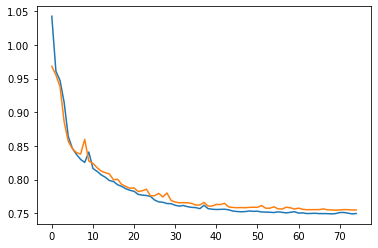

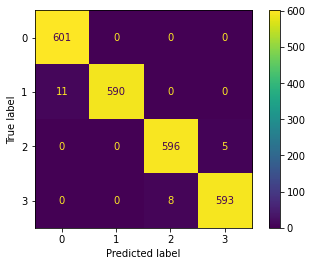

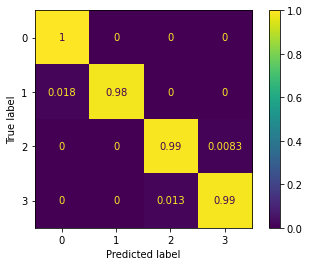

24


In [15]:
# training loop
test_loss = []
train_loss = []

for epoch in range(epochs):  # loop over the dataset multiple times
    train_loss += [train(train_dataloader, optimizer, criterion, model)]
    CM=split_test(test_dataloader, criterion, model)
    test_loss += [CM[4]]
print('Finished Training')
#print(CM[0])

plt.plot(train_loss)
plt.plot(test_loss)
plt.show()


disp = ConfusionMatrixDisplay(confusion_matrix=CM[0],display_labels=[0, 1, 2, 3])
disp.plot()
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=CM[1],display_labels=[0, 1, 2, 3])
disp.plot()
plt.show()

print(len(CM[2]))






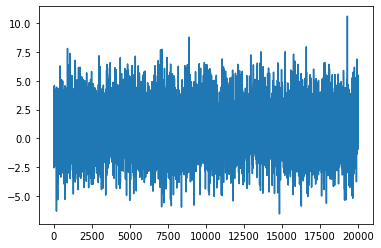

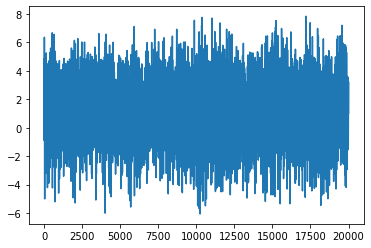

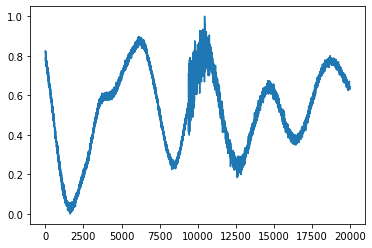

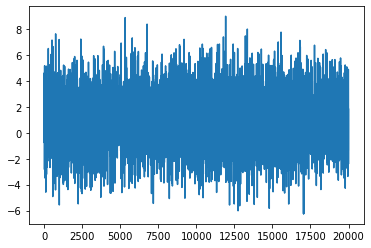

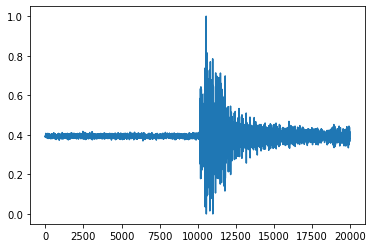

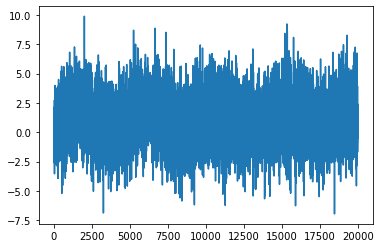

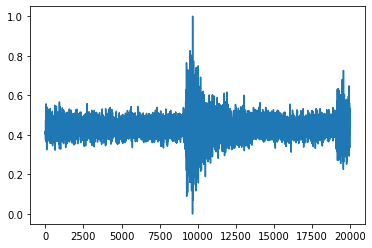

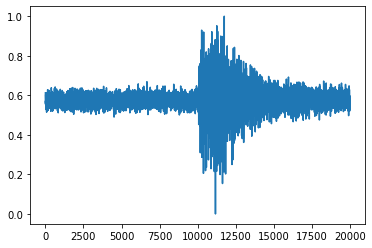

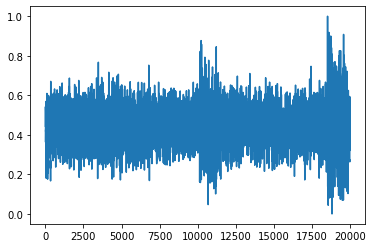

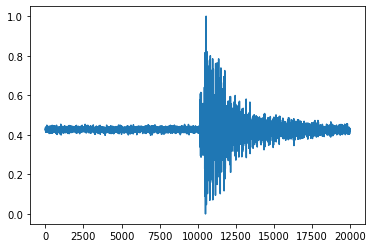

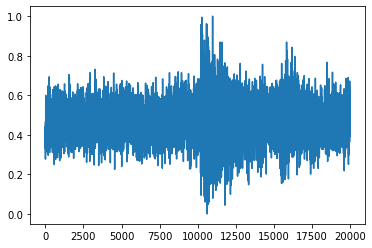

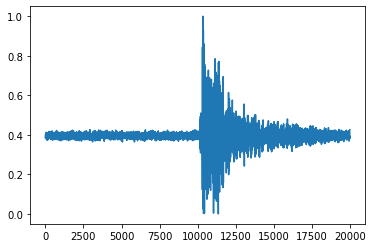

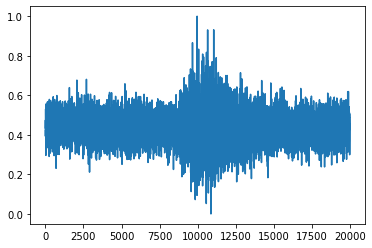

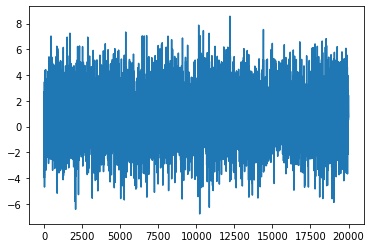

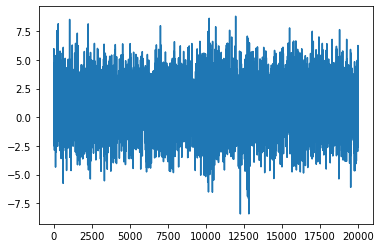

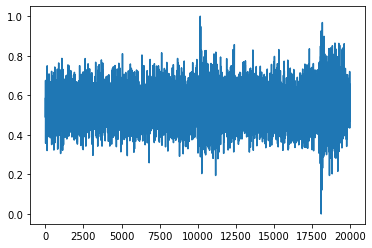

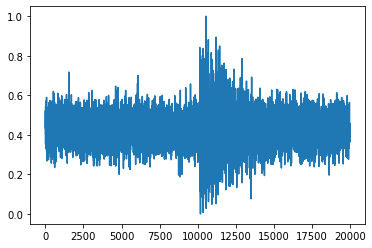

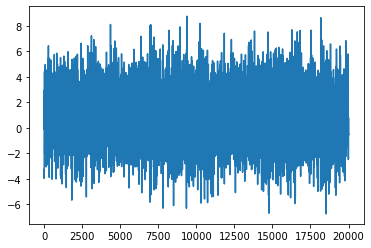

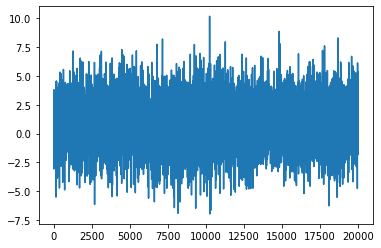

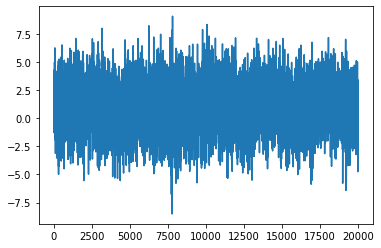

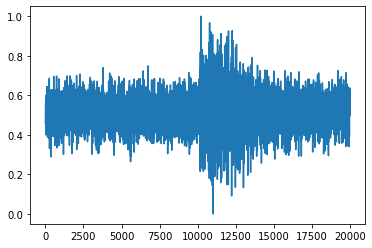

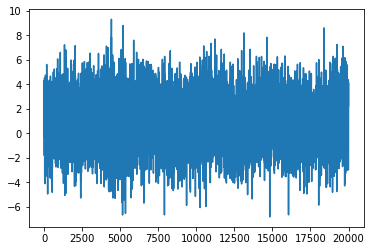

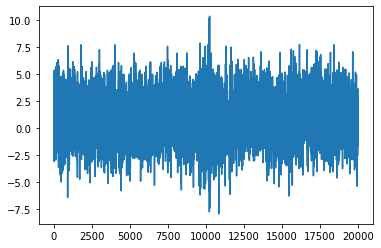

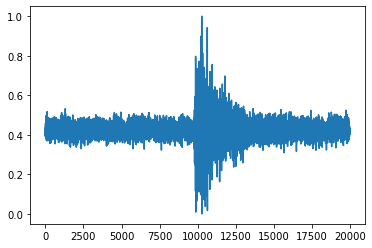

In [16]:
for i in CM[2]:    
    plt.plot(torch.flatten(i[0]).cpu())
    plt.show()

In [17]:
#seed = np.random.get_state()
#print(seed[1])
#df = pd.DataFrame(data = seed[1])
#df.to_csv("entladung_randomseed3.csv")

In [18]:
#torch.save(model.state_dict(), "/home/marcus/Dokumente/entladung/best_model")

In [19]:
def validation(dataloader):
    acc = []
    pred = []
    true = []
    model.eval()
    wrong_pred = []
    right_pred = []
    validation_loss = 0
    correct = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    print(f"{size} {num_batches}")
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels, inputs = labels.to(device), inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            acc.append((torch.argmax(outputs,axis=1)==labels).float().mean().item())
            pred.extend(list((torch.argmax(outputs,axis=1).cpu().numpy())))
            true.extend(list(labels.cpu().numpy()))
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            for i, output in enumerate(outputs):
                if output.argmax(0) != labels[i]:
                    wrong_pred.append([inputs[i], labels[i], output])
                elif output.argmax(0) == labels[i]:
                    right_pred.append([inputs[i], labels[i], output])
    validation_loss /= num_batches
    correct /= size
    return correct, validation_loss

In [20]:
validation(validation_dataloader)

4392 69


(0.9947632058287796, 0.7495254183161086)